**Notebook to analyse data collected at the plate reader over 20 hours.**


Wells contain three technical replicates of *Escherichia coli* with the Cre-*loxP* reporter on low-copy number plasmid reported on paper. The strains are induced with a gradient of concentration of the chemical inducer (cuminic acid). 


Instrument returns a spreadsheet with measurements (timedelta = 15 mins) of optical density at 600 $nm$, and fluorescence with 2 different gains (50) and (100).

In [24]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as md
import pandas as pd
import datetime 
import os
from typing import Tuple

In [25]:
dc =  './data' 
output_dir = './data/data_for_analysis'

# Preparing dataset

In [5]:
"""
Extract the first OD and fluorescence read from the datasheet and stor as df_start_*(tstep). 
This table is differently organized from the other reads.

"""

df_start_1 = pd.read_excel('%s/250304_Cuma_reads.xlsx' %(dc),sheet_name = 'Plate2',skiprows=59,nrows=24, index_col = 1)

In [6]:
    
def add_first_read(df_start,df,n): #('n' assumes values between 0,1,2 for OD,F1,F2)
    
    """
    Function add_first_read
    to insert t0 data as first line of the df. 

    Function takes as input:

    - df_start, pandas df of the first measurement per well
    - df, pandas df with the rest of measures
    - a variable n to indicate whether you are modifying the dataset of
        - OD data | n = 0
        - F1 data | n = 1
        - F2 data | n = 2

    Returns an updated df (previous version will still be saved if you don't name them the same)

    """
    
    df_start = df_start.T
    
    t = datetime.time(0,0,0)

    a = list(range(0,24,3))
    b = list(range(1,25,3))
    c = list(range(2,26,3))

    OD_start = [t,37]
    for item in a:
        l = list(df_start.iloc[1:13,item])
        OD_start += l 

    F1_start = [t,37]

    for item in b:
        l = list(df_start.iloc[1:13,item])
        F1_start += l 

    F2_start = [t,37]
    for item in c:
        l = list(df_start.iloc[1:13,item])
        F2_start += l 

    if n == 0: 

        df.loc[-1]= OD_start  # adding a row

    if n == 1: 

        df.loc[-1]= F1_start 

  
    if n == 2: 

        df.loc[-1]= F2_start 
  
    df.index = df.index + 1  # shifting index
    df = df.sort_index()

    return df


In [7]:
df_OD = pd.read_excel('%s/250304_Cuma_reads.xlsx'%(dc),sheet_name = 'Plate2',skiprows=87,nrows=60,index_col = 0)
df_F1 = pd.read_excel('%s/250304_Cuma_reads.xlsx'%(dc),sheet_name = 'Plate2',skiprows=212,nrows=60,index_col = 0)
df_F2 = pd.read_excel('%s/250304_Cuma_reads.xlsx'%(dc),sheet_name = 'Plate2',skiprows=337,nrows=60,index_col = 0)

df_OD = add_first_read(df_start_1,df_OD,0)
df_F1 = add_first_read(df_start_1,df_F1,1)
df_F2 = add_first_read(df_start_1,df_F2,2)

df_OD["Time"] = (pd.to_datetime(df_OD["Time"], format='%H:%M:%S')).dt.time
df_F1["Time"] = (pd.to_datetime(df_F1["Time"], format='%H:%M:%S')).dt.time
df_F2["Time"] = (pd.to_datetime(df_F2["Time"], format='%H:%M:%S')).dt.time

In [26]:
df_OD.to_csv('%s/OD_250304.csv'%(output_dir))

In [27]:
df_F2.to_csv('%s/F2_250304.csv'%(output_dir))

## Label samples and concentrations
Assign to each chemical inducer concentration the technical replicate wells per time step.

In [10]:
bEG36 = {'0':np.array(['D2','F11','G4']),
         '3': np.array(['B11','E8','G3']),
         '5': np.array(['B9','C8','D7']),
         '8': np.array(['B2','C10','G5']),
         '10': np.array(['D5','F3','F8'])}

bEG39 = {'0':np.array(['C9','D3','D8']),
         '2': np.array(['E6','F5','G6']),
         '4': np.array(['C11','E2','E4']),
         '10': np.array(['F6','G2','G8'])}

bAG56 = {'0':np.array(['B4','D11','G9']),
         '10': np.array(['B7','C4','D9']),
         '50': np.array(['C3','C7','G11']),
         '100': np.array(['C6','E5','E9'])}

bEG57 = {'0':np.array(['D6','E10','F7']),
         '3': np.array(['B3','C5','F9']),
         '5': np.array(['B10','E3','G10']),
         '8': np.array(['B5','D4','F10']),
         '10': np.array(['F2','G7','B6'])}

In [11]:
WT = {'0': np.array(['B8','C2','E7'])}
blank_wells = {'0': np.array(['D10','E11','F4'])}

In [12]:
well_labels = {'bEG36': bEG36, 'bEG39': bEG39, 'bAG56': bAG56, 'bEG57': bEG57, 'WT': WT, 'blank': blank_wells}

In [13]:
#On the x-axes plotting the time 
df_OD["Time"] = pd.to_datetime(df_OD["Time"],format = '%H:%M:%S',exact = False)
x = df_OD["Time"].values #convert into array

In [14]:
# Create new dataframe with strain and concentration as rows
df_metadata = pd.DataFrame(index=['strain', 'concentration'], columns=df_OD.columns[2:]) #Exclude Time and temp columns

# For each column in df_OD_nobkg
for col in df_OD.columns[2:]:
    
        
    # Find which strain and concentration this well belongs to
    for strain, conc_dict in well_labels.items():
        for conc, wells in conc_dict.items():
            if col in wells:
                # Add strain and concentration as rows
                df_metadata.loc['strain', col] = strain
                df_metadata.loc['concentration', col] = conc



In [15]:
# Drop columns where strain or concentration is NaN
df_metadata = df_metadata.dropna(axis=1)


In [16]:
df_metadata.to_csv('%s/metadata_250304.csv'%(output_dir))

# Plots

In [19]:
from matplotlib import figure
from matplotlib import rc
import seaborn as sns
from cycler import cycler  # Import the cycler module
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [17]:
#from https://github.com/hsharsh/matplotlib-plots

from pathlib import Path
from typing import Tuple, Union

from matplotlib.figure import Figure


def save_figure(
    figure: Figure,
    figure_name: str,
    figure_directory: Union[str, Path],
    figure_format: str = "pdf",
    figure_size: Tuple[float, float] = (6.4, 4),
    dpi: int = 300,
    transparent_png: bool = True,
) -> None:
    """Save a matplotlib figure to a file with specified format and settings.

    Args:
        figure: The matplotlib figure to save. If None, creates a new empty figure.
        figure_name: Name of the output file (without extension).
        figure_directory: Directory path where the figure will be saved.
        figure_format: Output format of the figure ('pdf' or 'png'). Defaults to 'pdf'.
        figure_size: Tuple of (width, height) in inches. Defaults to (6.4, 4).
        dpi: Dots per inch for PNG format. Defaults to 300.
        transparent_png: Whether to make PNG background transparent. Defaults to True.

    Raises:
        ValueError: If an unsupported figure format is provided.
        OSError: If there are issues creating the directory or saving the file.
    """
    try:
        # Validate figure format
        figure_format = figure_format.lower()
        if figure_format not in ["pdf", "png"]:
            raise ValueError(f"Unsupported figure format: {figure_format}")

        # Set figure size
        figure.set_size_inches(figure_size, forward=False)

        # Ensure directory exists
        figure_directory = Path(figure_directory)
        figure_directory.mkdir(parents=True, exist_ok=True)

        # Construct save path
        save_path = figure_directory / f"{figure_name}.{figure_format}"

        # Save figure based on format
        if figure_format == "pdf":
            figure.savefig(save_path, bbox_inches="tight")
        elif figure_format == "png":
            # Configure transparency
            alpha = 0 if transparent_png else 1
            figure.patch.set_alpha(alpha)

            # Set transparency for all axes
            for ax in figure.get_axes():
                ax.patch.set_alpha(alpha)

            # Save with PNG-specific settings
            figure.savefig(save_path, bbox_inches="tight", dpi=dpi)

    except OSError as e:
        raise OSError(f"Failed to save figure: {e}") from e
    except Exception as e:
        raise RuntimeError(f"Unexpected error while saving figure: {e}") from e



In [20]:
# Customizing plot elements
color_palette = sns.color_palette("colorblind")
color_palette_2 = sns.color_palette("hsv", 15)
custom_cycler = cycler(color=color_palette_2)
plt.rc('axes', prop_cycle=custom_cycler)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1

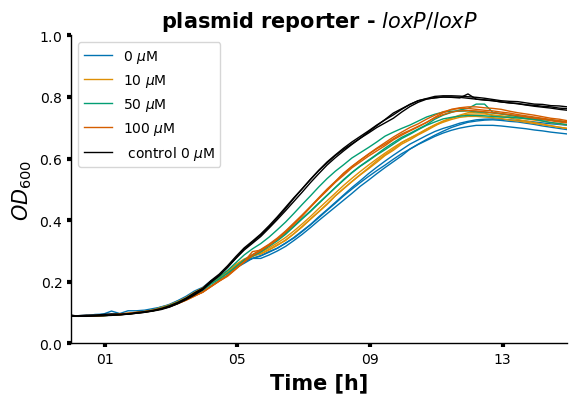

In [21]:
fig = plt.figure(figsize= (6.4,4))
ax = plt.gca()
color = 0
for key, item in bAG56.items():
   
    for i in range(len(item)):
        if i==0 :
            ax.plot(x,df_OD[item[i]], c = color_palette[color],label = "%s $\mu$M"%(key))
        else: 
            ax.plot(x,df_OD[item[i]], c = color_palette[color])
    color+=1

for key, item in WT.items():

     for i in range(len(item)): 
        if i==0 :
            ax.plot(x,df_OD[item[i]], c = 'k',label = " control %s $\mu$M"%(key))
        else: 
            ax.plot(x,df_OD[item[i]], c = 'k')
            
ax.set_title("plasmid reporter - $loxP/loxP$", fontsize = 15, fontweight = 'bold')

ax.legend(fontsize = 10, loc = 'upper left')

ax.set_ylabel("${OD}_{600}$",fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Time [h]", fontsize = 15, fontweight = 'bold')


ticks = [1,5,9,13]
plt.gca().set_xticks(ticks)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.xaxis.set_major_locator(md.HourLocator(interval=4))
ax.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

ax.yaxis.offsetText.set_visible(False)

ax.xaxis.set_tick_params(length = 3, width=3)
ax.yaxis.set_tick_params(length = 3,width=3)
ax.set_xlim(x[0],x[-1])
ax.set_ylim([0,1])

#plt.locator_params(axis='y', nbins=4)
#ax.spines['left'].set_position('zero')
# fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#save_figure(fig,figure_name = 'bAG56_OD_linlin_nobkg',figure_directory=output_dir)

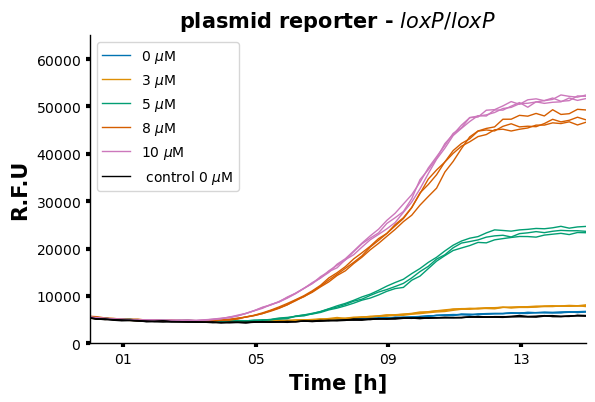

In [23]:
fig = plt.figure(figsize= (6.4,4))
ax = plt.gca()

color = 0
for key, item in bEG36.items():
   
    for i in range(len(item)):
        if i==0 :
            ax.plot(x,df_F2[item[i]], c = color_palette[color],label = "%s $\mu$M"%(key))
        else: 
            ax.plot(x,df_F2[item[i]], c = color_palette[color])
    color+=1
    
for key, item in WT.items():

     for i in range(len(item)): 
        if i==0 :
            ax.plot(x,df_F2[item[i]], c = 'k',label = " control %s $\mu$M"%(key))
        else: 
            ax.plot(x,df_F2[item[i]], c = 'k')

ax.set_title("plasmid reporter - $loxP/loxP$", fontsize = 15, fontweight = 'bold')

ax.legend(fontsize = 10, loc = 'upper left')

ax.set_ylabel("R.F.U",fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Time [h]", fontsize = 15, fontweight = 'bold')
ax.set_ylim([0,6.5e4])

ticks = [1,5,9,13]
plt.gca().set_xticks(ticks)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.xaxis.set_major_locator(md.HourLocator(interval=4))
ax.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

ax.yaxis.offsetText.set_visible(False)

ax.xaxis.set_tick_params(length = 3, width=3)
ax.yaxis.set_tick_params(length = 3,width=3)
ax.set_xlim(x[0],x[-1])

#plt.locator_params(axis='y', nbins=4)
#ax.spines['left'].set_position('zero')
# fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#save_figure(fig,figure_name = 'bEG36_F2_linlin',figure_directory=output_dir)

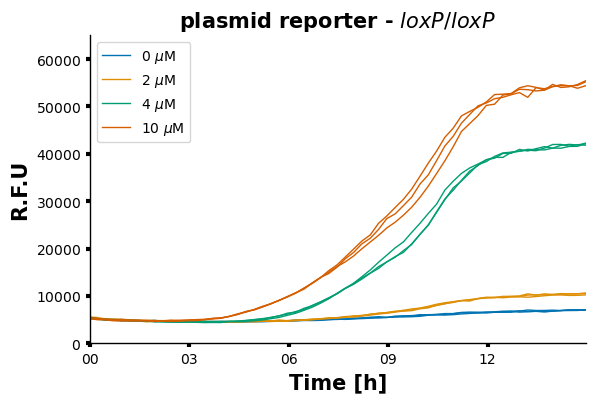

In [22]:
fig = plt.figure(figsize= (6.4,4))
ax = plt.gca()

color = 0
for key, item in bEG39.items():
   
    for i in range(len(item)):
        if i==0 :
            ax.plot(x,df_F2[item[i]], c = color_palette[color],label = "%s $\mu$M"%(key))
        else: 
            ax.plot(x,df_F2[item[i]], c = color_palette[color])
    color+=1
    
#for i in enumerate(WT):
   # if i[0] ==0 :
    #    ax.plot(x,df_F2_nobkg[i[1]], c = 'k',label = "control")
    #else: 
    #    ax.plot(x,df_F2_nobkg[i[1]], c = 'k')

ax.set_title("plasmid reporter - $loxP/loxP$", fontsize = 15, fontweight = 'bold')

ax.legend(fontsize = 10, loc = 'upper left')

ax.set_ylabel("R.F.U",fontsize = 15, fontweight = 'bold')
ax.set_xlabel("Time [h]", fontsize = 15, fontweight = 'bold')
ax.set_ylim([0,6.5e4])

ticks = [1,5,9,11,13]
plt.gca().set_xticks(ticks)

ax.tick_params(axis='both', which='major', labelsize=10)

ax.xaxis.set_major_locator(md.HourLocator(interval=3))
ax.xaxis.set_major_formatter(md.DateFormatter('%H'))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

ax.yaxis.offsetText.set_visible(False)

ax.xaxis.set_tick_params(length = 3, width=3)
ax.yaxis.set_tick_params(length = 3,width=3)
ax.set_xlim(x[0],x[-1])

#plt.locator_params(axis='y', nbins=4)
#ax.spines['left'].set_position('zero')
# fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#save_figure(fig,figure_name = 'bEG39_F2_linlin',figure_directory=output_dir)